In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
!pip install pandasql
from pandasql import sqldf
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [9]:
df = pd.read_csv("/content/churn.csv")

In [10]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Data Exploration

In [11]:
df[df['CustomerId'].duplicated(keep=False)]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


We can see that Customerid column has no duplicate

In [12]:
total_germany = len(df.loc[df['Geography'].str.contains('Germany')].Exited)
total_france = len(df.loc[df['Geography'].str.contains('France')].Exited)
total_spain = len(df.loc[df['Geography'].str.contains('Spain')].Exited)

total_male = len(df.loc[df['Gender'].str.contains('Male')].Exited)
total_female = len(df.loc[df['Gender'].str.contains('Female')].Exited)

total_hascrcard_0 = len(df.loc[df['HasCrCard'] == 0].Exited)
total_hascrcard_1 = len(df.loc[df['HasCrCard'] == 1].Exited)

total_activemember_0 = len(df.loc[df['IsActiveMember'] == 0].Exited)
total_activemember_1 = len(df.loc[df['IsActiveMember'] == 1].Exited)

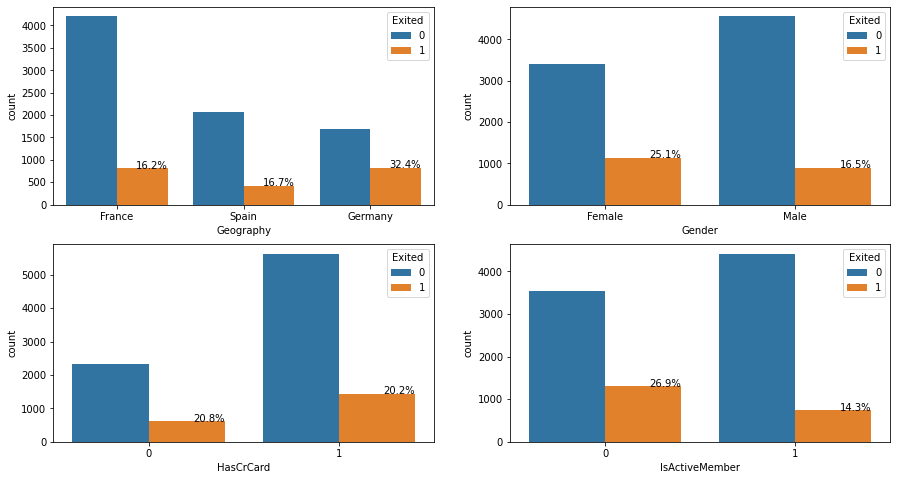

In [13]:
fig, sty = plt.subplots(2, 2, figsize=(15, 8))

total1 = [total_france,total_spain,total_germany]
ax1 = sns.countplot(data = df, x='Geography', hue='Exited',ax=sty[0][0])
patches1 = ax1.patches[3:6]
for p,total in zip(patches1,total1):
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax1.annotate(percentage, (x, y),ha='right')

total2 = [total_female,total_male]
ax2 = sns.countplot(data = df, x='Gender', hue = 'Exited', ax = sty[0][1])
patches2 = ax2.patches[2:4]
for p,total in zip(patches2,total2):
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax2.annotate(percentage, (x, y),ha='right')
    
total3 = [total_hascrcard_0,total_hascrcard_1]
ax3 = sns.countplot(data = df, x='HasCrCard', hue = 'Exited',ax = sty[1][0])
patches3 = ax3.patches[2:4]
for p,total in zip(patches3,total3):
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax3.annotate(percentage, (x, y),ha='right')
    
total4 = [total_activemember_0,total_activemember_1]
ax4 = sns.countplot(data = df, x='IsActiveMember', hue = 'Exited', ax = sty[1][1])
patches4 = ax4.patches[2:4]
for p,total in zip(patches4,total4):
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax4.annotate(percentage, (x, y),ha='right')

plt.show()

We can see that:
> The customer in Germany, the female customer, and the customer that's not an active member is more likely to churn

### Balance & Salary

Initial Hypothesis:
> If the ratio between balance and salary is high, it means that the customer fill most of their salary to their balance account and more likely to stay

In [14]:
df['Bal_Sal_Ratio'] = df['Balance']/df['EstimatedSalary']

In [15]:
sqldf('SELECT Balance,EstimatedSalary as Salary,Bal_Sal_Ratio from df') 

,Balance,Salary,Bal_Sal_Ratio
0,0.00,101348.88,0.000000
1,83807.86,112542.58,0.744677
2,159660.80,113931.57,1.401375
3,0.00,93826.63,0.000000
4,125510.82,79084.10,1.587055
...,...,...,...
9995,0.00,96270.64,0.000000
9996,57369.61,101699.77,0.564108
9997,0.00,42085.58,0.000000
9998,75075.31,92888.52,0.808230


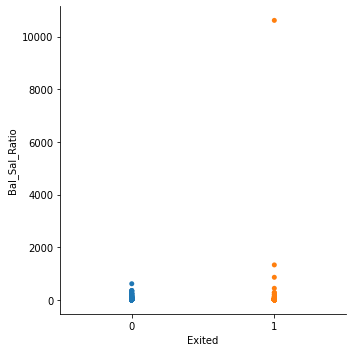

In [16]:
sns.catplot(x="Exited", y="Bal_Sal_Ratio", jitter=False, data=df)

It's very absurd to see the outlier above, and then the cause will be analyzed

In [17]:
sqldf("SELECT * FROM df WHERE Bal_Sal_Ratio>100 ORDER BY Bal_Sal_Ratio DESC")

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Bal_Sal_Ratio
0,2363,15791053,Lucciano,709,Germany,Male,45,4,122917.71,1,1,1,11.58,1,10614.655440
1,9011,15786463,Hsing,645,Germany,Female,59,8,121669.93,2,0,0,91.75,1,1326.102779
2,7566,15623369,Clifton,708,France,Male,52,10,105355.81,1,1,0,123.07,1,856.064110
3,8723,15718667,T'ien,621,France,Male,35,7,87619.29,1,1,0,143.34,0,611.268941
4,1463,15566211,Hsu,616,Germany,Female,41,1,103560.57,1,1,0,236.45,1,437.980842
5,3447,15764654,Zikoranachidimma,649,France,Male,37,9,87374.88,2,1,1,247.36,0,353.229625
6,2047,15733429,Chou,520,Germany,Male,34,8,120018.86,2,1,1,343.38,0,349.521987
7,6957,15696605,Angelo,571,France,Male,49,4,180614.04,1,0,0,523.00,0,345.342333
8,5121,15701176,Brown,663,France,Male,26,5,141462.13,1,1,0,440.20,0,321.358769
9,196,15594815,Aleshire,807,France,Male,35,3,174790.15,1,1,1,600.36,0,291.142231


There are people who have a high balance in their account but have a very low salary. It can be said that this kind of people fill their balance account with other things such as credit or passive income, or maybe the bank gives a poor estimate on the customer's salary.

**Missing Information** :
1. Customer's job or income
2. How the bank estimated the customer's salary (it's clearly not based on the balance)

### Age & Tenure

Initial hypothesis:
> 1. The customer that has a long tenure are more likely to stay
2. The customer who started at an old age are more likely to stay

In [18]:
sorted(df['Tenure'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [19]:
Dict_tenure = {}

for i in range(0,11):
    Dict_tenure[f"total_tenure_{i}"] = len(df[df["Tenure"] == i])
    
Dict_tenure

{'total_tenure_0': 413,
 'total_tenure_1': 1035,
 'total_tenure_10': 490,
 'total_tenure_2': 1048,
 'total_tenure_3': 1009,
 'total_tenure_4': 989,
 'total_tenure_5': 1012,
 'total_tenure_6': 967,
 'total_tenure_7': 1028,
 'total_tenure_8': 1025,
 'total_tenure_9': 984}

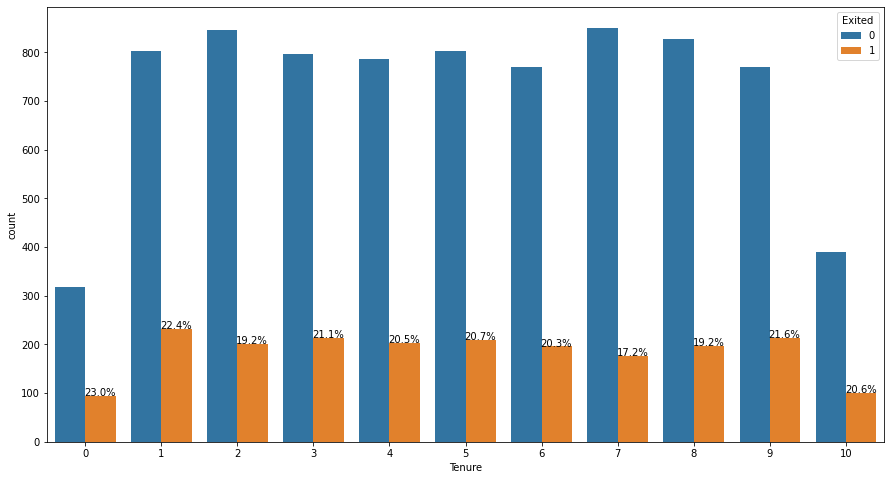

In [20]:
fig = plt.subplots(figsize=(15, 8))
total = list(Dict_tenure.values())
ax = sns.countplot(data = df, x='Tenure', hue = 'Exited')
patches = ax.patches[11:22]
for p,total in zip(patches,total):
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')

We can see that customer's tenure doesn't really affect whether customer will churned or not

In [21]:
df['age_start'] = df['Age'] - df['Tenure']

In [22]:
dfc = df.copy()
dfc['age_start_40_50'] = dfc['age_start'].apply(lambda x: 1 if x > 40 and x<50 else 0)
dfc['age_start_50_60'] = dfc['age_start'].apply(lambda x: 1 if x > 50 and x<60 else 0)
dfc['age_start_60_70'] = dfc['age_start'].apply(lambda x: 1 if x > 60 and x<70 else 0)
dfc['age_start_>_70'] = dfc['age_start'].apply(lambda x: 1 if x > 70 else 0)
dfc['age_start_<_40'] = dfc['age_start'].apply(lambda x: 1 if x < 40 else 0)

In [23]:
dfc['age_start_range'] = dfc['age_start'].apply(lambda x: 'age_start_40_50' if x > 40 and x<50 
                                               else 'age_start_50_60' if x > 50 and x<60
                                               else 'age_start_60_70' if x > 60 and x<70
                                               else 'age_start_>_70' if x > 70
                                               else 'age_start_<_40')

In [24]:
dict_age = {}
age_range = ['<40','40_50','50_60','60_70','>70']
age_column = ['age_start_<_40','age_start_40_50','age_start_50_60','age_start_60_70','age_start_>_70']
for i,age in zip(age_range,age_column):
    dict_age[f"total_exited_{i}"] = len(dfc[dfc[age] ==1])
    
dict_age

{'total_exited_40_50': 1336,
 'total_exited_50_60': 517,
 'total_exited_60_70': 210,
 'total_exited_<40': 7537,
 'total_exited_>70': 55}

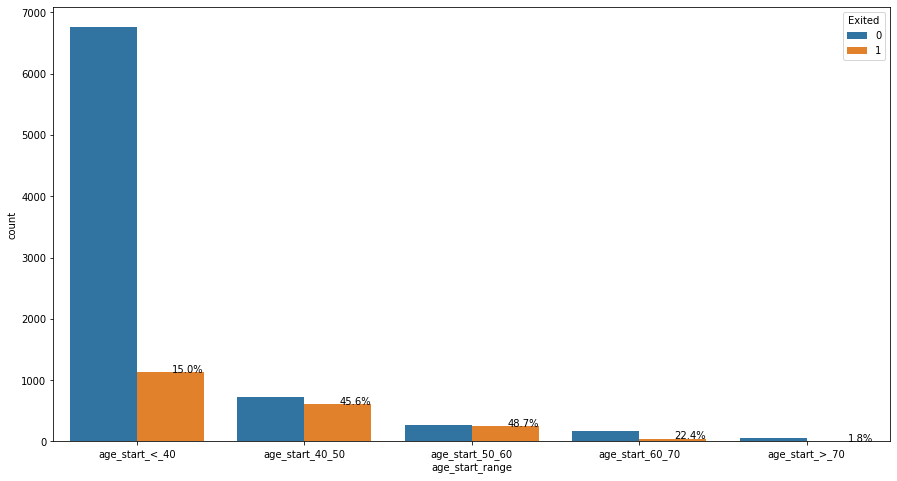

In [25]:
fig = plt.subplots(figsize=(15, 8))
total = list(dict_age.values())
ax = sns.countplot(data = dfc, x='age_start_range', hue = 'Exited')
patches = ax.patches[5:10]
for p,total in zip(patches,total):
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')

In [29]:
print(sqldf("SELECT COUNT(Exited) as age_start_40_50, Exited from dfc where age_start_40_50=1 group by exited"))
print(sqldf("SELECT COUNT(Exited) as age_start_50_60, Exited from dfc where age_start_50_60=1 group by exited"))
print(sqldf("SELECT COUNT(Exited) as age_start_60_70, Exited from dfc where age_start_60_70=1 group by exited"))

   age_start_40_50  Exited
0              727       0
1              609       1
   age_start_50_60  Exited
0              265       0
1              252       1
   age_start_60_70  Exited
0              163       0
1               47       1


> As we can see, the customer who started at between age 40 to 60 are more than likely to churn, this is counterintuitive to the initial hypothesis.

### Country

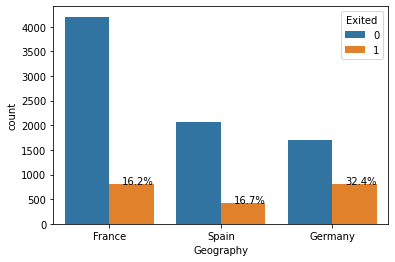

In [30]:
total1 = [total_france,total_spain,total_germany]
ax1 = sns.countplot(data = df, x='Geography', hue='Exited')
patches1 = ax1.patches[3:6]
for p,total in zip(patches1,total1):
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax1.annotate(percentage, (x, y),ha='right')
    
plt.show()

In [31]:
sqldf("SELECT AVG(Balance) as Average_Balance, Geography from df GROUP BY Geography ORDER BY AVG(Balance) DESC")

,Average_Balance,Geography
0,119730.116134,Germany
1,62092.636516,France
2,61818.147763,Spain


In [32]:
sqldf("SELECT AVG(EstimatedSalary) as AVG_Salary, Geography from df GROUP BY Geography ORDER BY AVG(EstimatedSalary) DESC")

,AVG_Salary,Geography
0,101113.435102,Germany
1,99899.180814,France
2,99440.572281,Spain


In [33]:
sqldf("SELECT COUNT(Exited) as Count_Exited, Geography from df WHERE Exited=1 GROUP BY Geography ORDER BY COUNT(Exited) DESC")

,Count_Exited,Geography
0,814,Germany
1,810,France
2,413,Spain


We can see that even though Germany is the richest country in this data, they have the most costumer exit.

## Data Preparation

### 1. Clean useless column & check NA Values

In [34]:
list(df)

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'Bal_Sal_Ratio',
 'age_start']

In [35]:
# drop columns that have no use
df1 = df.drop(["RowNumber","CustomerId","Surname"], axis=1)

In [36]:
df1.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
Bal_Sal_Ratio      0
age_start          0
dtype: int64

### 2. Feature Engineering

In [37]:
{column: list(df1[column].unique()) for column in df1.select_dtypes('object').columns}

{'Gender': ['Female', 'Male'], 'Geography': ['France', 'Spain', 'Germany']}

*Geography* will be one hot encoded and *Gender* will be binary encoded

In [38]:
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [39]:
pd.get_dummies(df1["Geography"])

,France,Germany,Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
9995,1,0,0
9996,1,0,0
9997,1,0,0
9998,0,1,0


In [40]:
def encode(df):
    df = df.copy()
    
    # Encode Gender column
    df = binary_encode(df, 'Gender', positive_value='Male')
    
    # Encode Geography column
    df = onehot_encode(df, 'Geography', prefix='Country')
    
    return df

In [41]:
df1 = encode(df1)
df1

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Bal_Sal_Ratio,age_start,Country_France,Country_Germany,Country_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0.000000,40,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.744677,40,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.401375,34,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0.000000,38,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,1.587055,41,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,0,0.000000,34,1,0,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,0.564108,25,1,0,0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,0.000000,29,1,0,0
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,0.808230,39,0,1,0


### 3. Multivariate Analysis

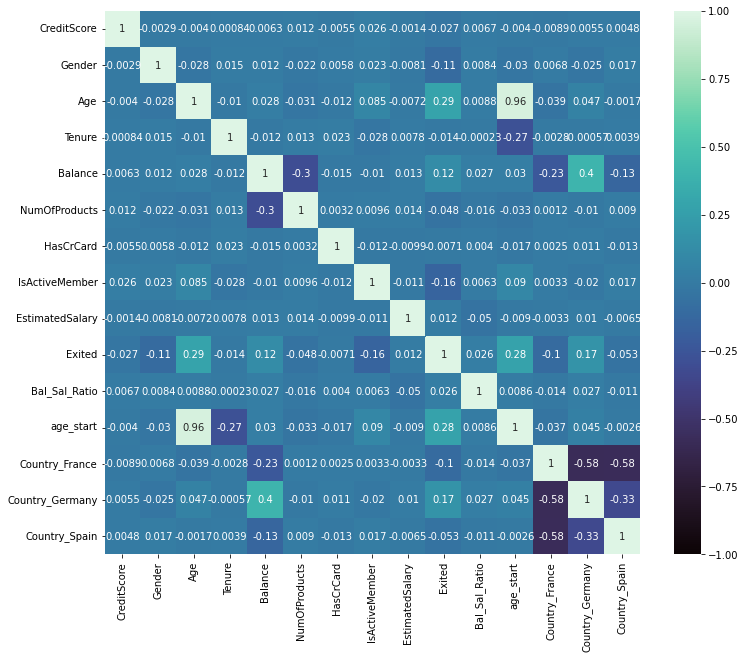

In [42]:
corr = df1.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.show()

- We can see that the only country that has positive correlation value with Balance and Estimated Salary is Germany. That means basically people in Germany are richer than people in Spain and France
- The bank have a poor judgement in giving Credit Score, as the correlation between *Exited* and *CreditScore* is very low
- Correlation between country variables is considerably high, therefore for glm model, country variables will be removed to prevent multicollinearity

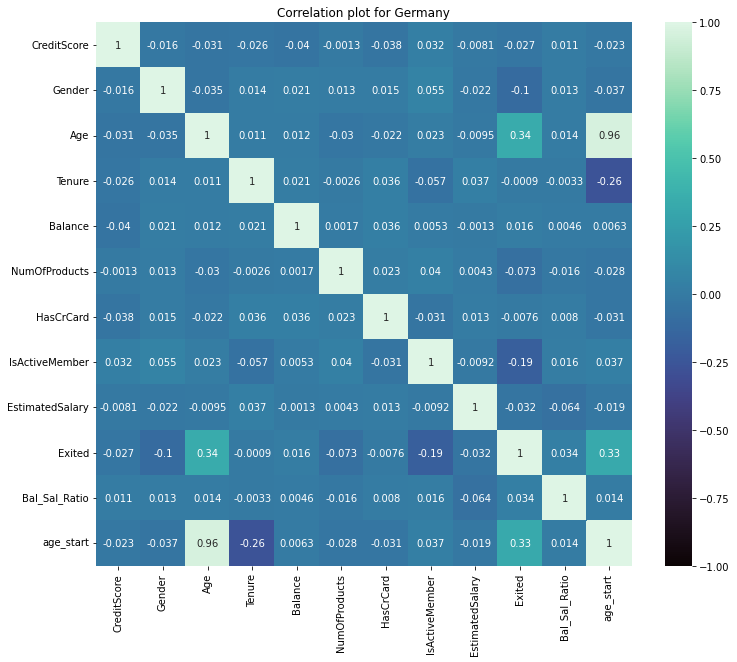

In [43]:
corr_germany = df1.loc[df1['Country_Germany']==1].drop(['Country_France','Country_Spain','Country_Germany'],1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_germany, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation plot for Germany')
plt.show()

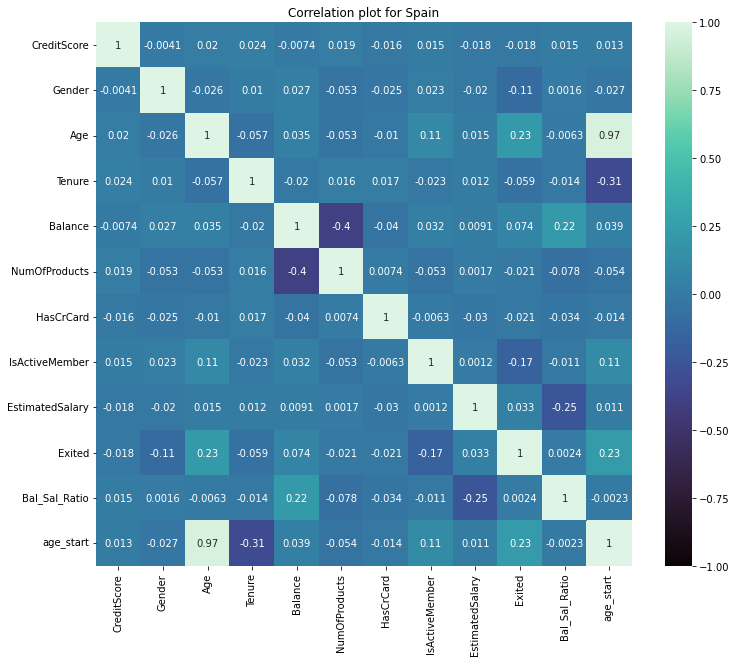

In [44]:
corr_spain = df1.loc[df1['Country_Spain']==1].drop(['Country_France','Country_Spain','Country_Germany'],1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_spain, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation plot for Spain')
plt.show()

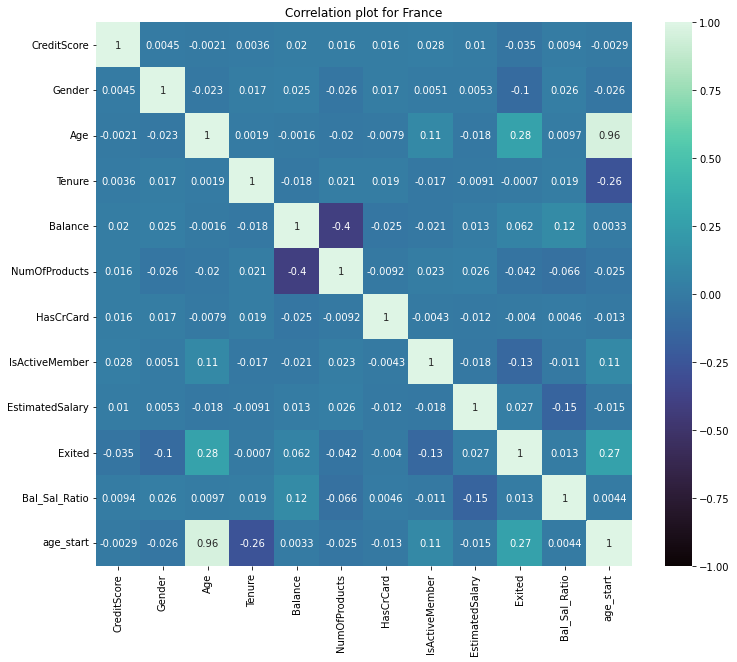

In [45]:
corr_france = df1.loc[df1['Country_France']==1].drop(['Country_France','Country_Spain','Country_Germany'],1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_france, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation plot for France')
plt.show()

### 4. Data Cleansing

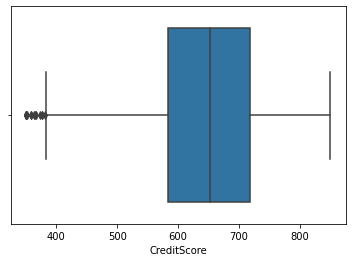

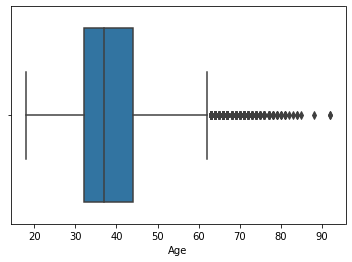

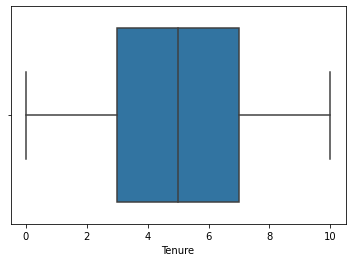

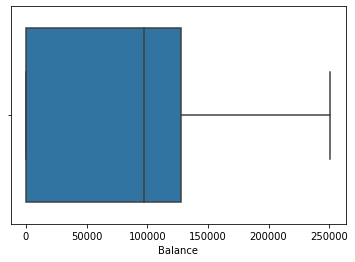

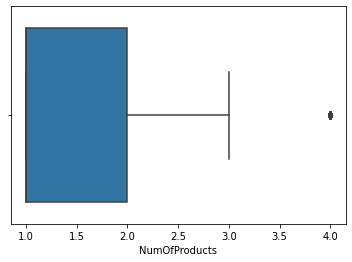

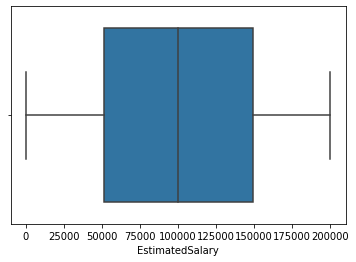

In [46]:
outlier_plot = ["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary"]
for i in outlier_plot:
    sns.boxplot(x = df1[i])
    plt.show()

We can see that CreditScore, Age, NumOfProducts have outliers

In [47]:
def outlier_cleaner(df,column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_boundary = q1 - 1.5 * iqr
    upper_boundary = q3 + 1.5 * iqr
    cleaned_data = df.loc[(df[column] > lower_boundary) & (df[column] < upper_boundary)]
    return cleaned_data

In [48]:
def clean_outlier_columns(df):
    df = df.copy()
    
    # Clean outliers in CreditScore column
    df = outlier_cleaner(df,'CreditScore')
    
    # Clean outliers in Age column
    df = outlier_cleaner(df,'Age')
    
    # Clean outliers in NumOfProducts column
    df = outlier_cleaner(df,'NumOfProducts')
    
    return df


In [49]:
df_cleaned = clean_outlier_columns(df1)

In [50]:
print(df1.shape)
print(df_cleaned.shape)

(10000, 15)
(9515, 15)


### 5. Feature Scaling

In [51]:
def splitter(df):
    # Split df into X and y
    y = df['Exited'].copy()
    X = df.drop('Exited', axis=1).copy()
    
    # Scale X with a standard scaler
    #scaler = StandardScaler()
    #X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y

In [52]:
X, y = splitter(df_cleaned)

In [53]:
X

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Bal_Sal_Ratio,age_start,Country_France,Country_Germany,Country_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,0.000000,40,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0.744677,40,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1.401375,34,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0.000000,38,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,1.587055,41,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,0.000000,34,1,0,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0.564108,25,1,0,0
9997,709,0,36,7,0.00,1,0,1,42085.58,0.000000,29,1,0,0
9998,772,1,42,3,75075.31,2,1,0,92888.52,0.808230,39,0,1,0


## Modelling

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

### Dealing with imbalanced dataset
> Balancing the data is necessary, otherwise the model will perform badly

In [55]:
y_train.value_counts()

0    5343
1    1317
Name: Exited, dtype: int64

In [56]:
# SMOTE
from imblearn.over_sampling import SMOTE
X_train_SMOTE, y_train_SMOTE = SMOTE().fit_resample(X_train, y_train)

# Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

### Decision Tree

#### Using SMOTE

In [57]:
dctree = DecisionTreeClassifier(max_depth =3, random_state = 42)
dctree_SMOTE = dctree.fit(X_train_SMOTE,y_train_SMOTE)

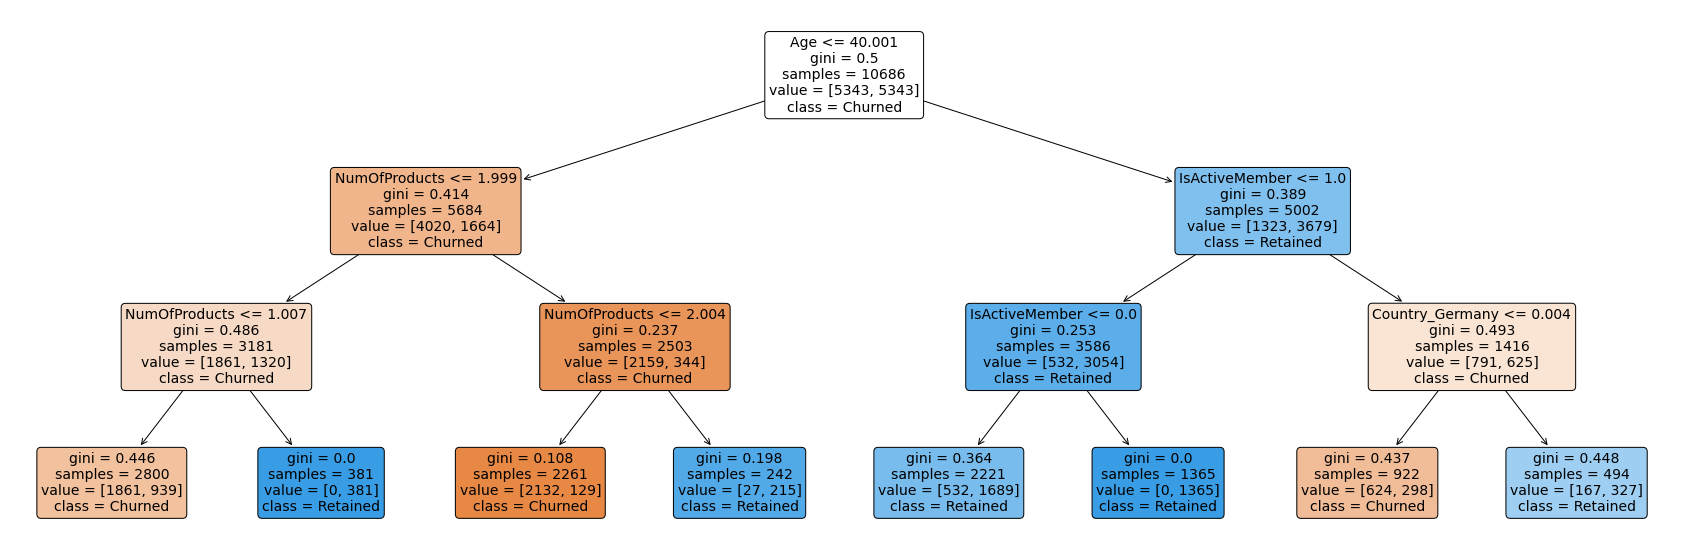

In [65]:
plt.figure(figsize=(30,10))
a = tree.plot_tree(dctree_SMOTE,
                   feature_names = list(X),
                   class_names = ['Churned','Retained'],
                   rounded = True,
                   filled = True,
                   fontsize=14)

plt.show()

In [66]:
pred_dctree_SMOTE = dctree_SMOTE.predict(X_test)

In [67]:
print(metrics.classification_report(y_test, pred_dctree_SMOTE))
print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_dctree_SMOTE))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      2303
           1       0.49      0.56      0.52       552

    accuracy                           0.80      2855
   macro avg       0.69      0.71      0.70      2855
weighted avg       0.81      0.80      0.81      2855

ROC AUC score for oversampled SMOTE data:  0.7086424764170238


#### Using Random Undersampling

In [68]:
dctree_under = dctree.fit(X_train_under,y_train_under)

In [69]:
pred_dctree_under = dctree_under.predict(X_test)
print(metrics.classification_report(y_test, pred_dctree_under))
print("ROC AUC score for Undersampled data: ", roc_auc_score(y_test, pred_dctree_under))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2303
           1       0.48      0.65      0.55       552

    accuracy                           0.80      2855
   macro avg       0.69      0.74      0.71      2855
weighted avg       0.82      0.80      0.81      2855

ROC AUC score for Undersampled data:  0.7386973984783552


> Because for the Undersampled data ROC AUC score and F1 score is higher, then for parameter tuning, Undersampled data will be used

#### Parameter Tuning

In [70]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'max_depth': list(range(1,10)), 
                     'min_samples_split': list(range(2,10))}]
scores = ['f1']

In [111]:
for score in scores:
    
    print()
    print(f"Tuning hyperparameters for {score}")
    print()
    
    clf = GridSearchCV(
        DecisionTreeClassifier(), tuned_parameters,
        scoring = f'{score}'
    )
    clf.fit(X_train_under, y_train_under)
    
    print("Best parameters set:")
    print()
    print(clf.best_params_)


Tuning hyperparameters for f1

Best parameters set:

{'max_depth': 4, 'min_samples_split': 2}


In [110]:
clf.best_params_['min_samples_split']

7

In [112]:
dctree_optimal = DecisionTreeClassifier(max_depth =clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state = 42)
dctree_optimal = dctree_optimal.fit(X_train_under,y_train_under)
pred_dctree_optimal = dctree_optimal.predict(X_test)
print(metrics.classification_report(y_test, pred_dctree_optimal))
print("ROC AUC score for Optimal model: ", roc_auc_score(y_test, pred_dctree_optimal))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      2303
           1       0.42      0.77      0.55       552

    accuracy                           0.75      2855
   macro avg       0.68      0.76      0.69      2855
weighted avg       0.83      0.75      0.78      2855

ROC AUC score for Optimal model:  0.7583150050029261


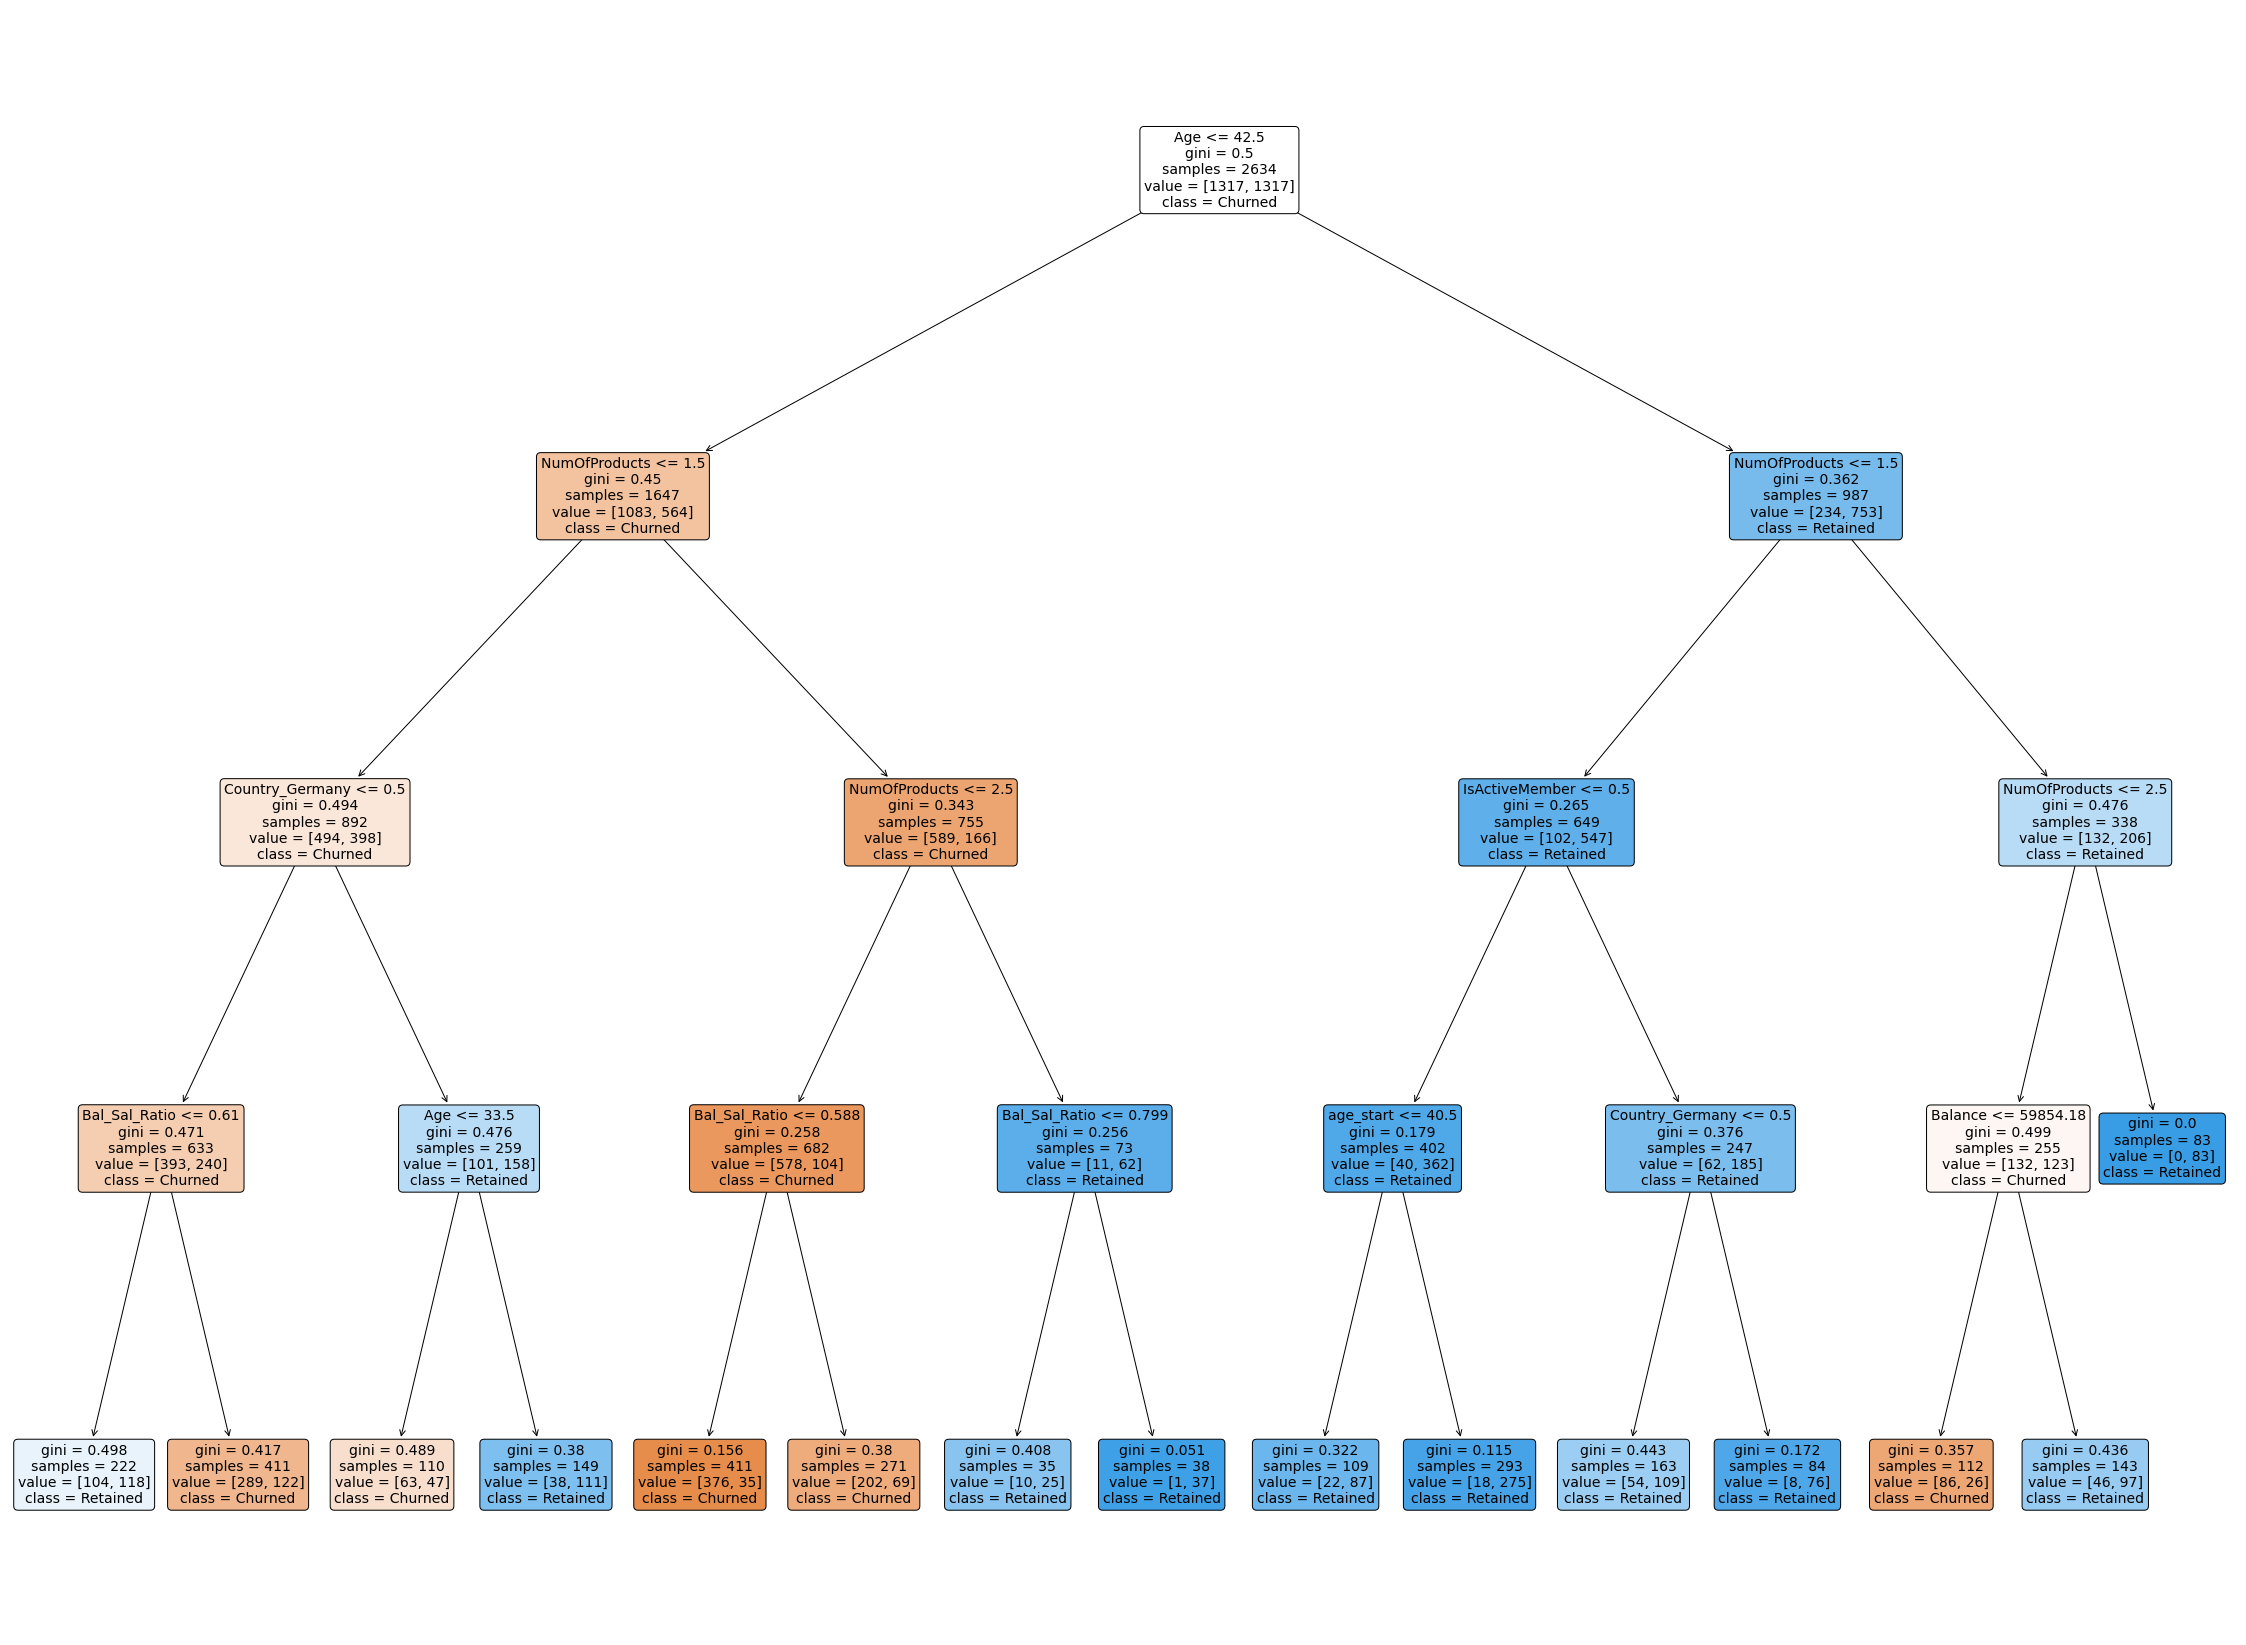

In [113]:
plt.figure(figsize=(40,30))
a = tree.plot_tree(dctree_optimal,
                   feature_names = list(X),
                   class_names = ['Churned','Retained'],
                   rounded = True,
                   filled = True,
                   fontsize=14)

plt.show()

### Random Forest

#### SMOTE

In [114]:
rf_SMOTE = RandomForestClassifier(bootstrap = True, max_features = 'sqrt')
rf_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
pred_rf_SMOTE = rf_SMOTE.predict(X_test)
print(metrics.classification_report(y_test, pred_rf_SMOTE))
print("ROC AUC score for SMOTE data: ", roc_auc_score(y_test, pred_rf_SMOTE))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      2303
           1       0.69      0.48      0.57       552

    accuracy                           0.86      2855
   macro avg       0.79      0.71      0.74      2855
weighted avg       0.85      0.86      0.85      2855

ROC AUC score for SMOTE data:  0.7139458928807415


#### Random Undersampling

In [115]:
rf_under = RandomForestClassifier(bootstrap = True, max_features = 'sqrt')
rf_under.fit(X_train_under, y_train_under)
pred_rf_under = rf_under.predict(X_test)
print(metrics.classification_report(y_test, pred_rf_under))
print("ROC AUC score for Undersampled data: ", roc_auc_score(y_test, pred_rf_under))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      2303
           1       0.45      0.76      0.56       552

    accuracy                           0.77      2855
   macro avg       0.69      0.77      0.70      2855
weighted avg       0.84      0.77      0.79      2855

ROC AUC score for Undersampled data:  0.7656896014650079


> Because for the SMOTE data F1 score is higher even though ROC AUC score is lower, then for parameter tuning, SMOTE data will be used

#### Parameter Tuning

In [116]:
from sklearn.model_selection import GridSearchCV
tuned_parameters_rf = [{'n_estimators': [100,300,500], 
                       'max_depth': [3,5,7],
                       'max_features': [3,5,7]}]
scores = ['f1']

In [117]:
for score in scores:
    
    print()
    print(f"Tuning hyperparameters for {score}")
    print()
    
    clf = GridSearchCV(
        RandomForestClassifier(), tuned_parameters_rf,
        scoring = f'{score}'
    )
    clf.fit(X_train_SMOTE, y_train_SMOTE)
    
    print("Best parameters set:")
    print()
    print(clf.best_params_)


Tuning hyperparameters for f1

Best parameters set:

{'max_depth': 7, 'max_features': 3, 'n_estimators': 500}


In [119]:
clf.best_params_['max_depth']

7

In [120]:
rf_optimal = RandomForestClassifier(bootstrap = True, max_features = clf.best_params_['max_features'], max_depth = clf.best_params_['max_depth'],random_state=300)
rf_optimal.fit(X_train_SMOTE, y_train_SMOTE)
pred_rf_optimal = rf_optimal.predict(X_test)
print(metrics.classification_report(y_test, pred_rf_optimal))
print("ROC AUC score for optimal model: ", roc_auc_score(y_test, pred_rf_optimal))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2303
           1       0.63      0.55      0.59       552

    accuracy                           0.85      2855
   macro avg       0.76      0.74      0.75      2855
weighted avg       0.84      0.85      0.85      2855

ROC AUC score for optimal model:  0.736934181628248


#### Feature Importance

Text(0.5, 0, 'Relative Importance')

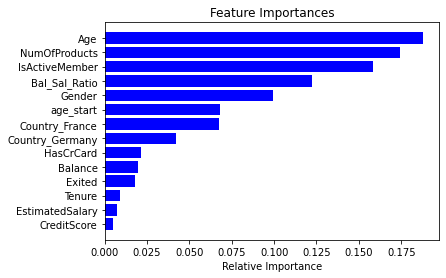

In [121]:
# Feature Importance
from matplotlib import pyplot
importance_rf = rf_optimal.feature_importances_
features=df_cleaned.columns
indices = np.argsort(importance_rf)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importance_rf[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

### Logistic Regression

#### Removing multicollinearity variables

In [122]:
list(X)

['CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Bal_Sal_Ratio',
 'age_start',
 'Country_France',
 'Country_Germany',
 'Country_Spain']

In [123]:
delvar = ['Country_Spain','age_start','Country_France']

In [124]:
X_train_log = X_train.drop(delvar,1)
X_test_log = X_test.drop(delvar,1)

#### Balancing the data

In [125]:
# SMOTE
from imblearn.over_sampling import SMOTE
X_train_log_SMOTE, y_train_SMOTE = SMOTE().fit_resample(X_train_log, y_train)

# Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_log_under, y_train_under = undersample.fit_resample(X_train_log, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [126]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train_log, y_train)
pred_log = logreg.predict(X_test_log)
print(metrics.classification_report(y_test, pred_log))
print("ROC AUC score for optimal model: ", roc_auc_score(y_test, pred_log))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      2303
           1       0.46      0.08      0.14       552

    accuracy                           0.80      2855
   macro avg       0.64      0.53      0.51      2855
weighted avg       0.75      0.80      0.74      2855

ROC AUC score for optimal model:  0.5294712473333459


#### SMOTE

In [127]:
logreg_SMOTE = logreg.fit(X_train_log_SMOTE, y_train_SMOTE)
pred_log_SMOTE = logreg.predict(X_test_log)
print(metrics.classification_report(y_test, pred_log_SMOTE))
print("ROC AUC score for optimal model: ", roc_auc_score(y_test, pred_log_SMOTE))

              precision    recall  f1-score   support

           0       0.90      0.65      0.75      2303
           1       0.32      0.69      0.44       552

    accuracy                           0.66      2855
   macro avg       0.61      0.67      0.59      2855
weighted avg       0.79      0.66      0.69      2855

ROC AUC score for optimal model:  0.6699771721824715


#### Random Undersampling

In [128]:
logreg_under = logreg.fit(X_train_log_under, y_train_under)
pred_log_under = logreg.predict(X_test_log)
print(metrics.classification_report(y_test, pred_log_under))
print("ROC AUC score for optimal model: ", roc_auc_score(y_test, pred_log_under))

              precision    recall  f1-score   support

           0       0.85      0.48      0.61      2303
           1       0.23      0.65      0.34       552

    accuracy                           0.51      2855
   macro avg       0.54      0.57      0.48      2855
weighted avg       0.73      0.51      0.56      2855

ROC AUC score for optimal model:  0.5668972260504572


# Model Conclusion

In [129]:
models = [pred_dctree_optimal,pred_rf_optimal,pred_log_SMOTE]
model_names = [
    "         Decision Tree F1 Score",
    "         Random Forest F1 Score",
    "   Logistic Regression F1 Score",
]

for model, name in zip(models, model_names):
    print(name + ": {}".format(metrics.f1_score(y_test, model)))

         Decision Tree F1 Score: 0.5458064516129032
         Random Forest F1 Score: 0.5885769603097774
   Logistic Regression F1 Score: 0.4377142857142857


> 1. The best model is Random Forest with F1 as the metric
2. The most important variables to predict churned customer is Age, IsActiveMember, NumOfProducts